In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from random import choices
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoLars as Lasso

%matplotlib inline

### First glance at the data

In [2]:
df = pd.read_csv('data/melburn_data.csv', index_col='Unnamed: 0')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18396 entries, 1 to 23546
Data columns (total 21 columns):
Suburb           18396 non-null object
Address          18396 non-null object
Rooms            18396 non-null int64
Type             18396 non-null object
Price            18396 non-null float64
Method           18396 non-null object
SellerG          18396 non-null object
Date             18396 non-null object
Distance         18395 non-null float64
Postcode         18395 non-null float64
Bedroom2         14927 non-null float64
Bathroom         14925 non-null float64
Car              14820 non-null float64
Landsize         13603 non-null float64
BuildingArea     7762 non-null float64
YearBuilt        8958 non-null float64
CouncilArea      12233 non-null object
Lattitude        15064 non-null float64
Longtitude       15064 non-null float64
Regionname       18395 non-null object
Propertycount    18395 non-null float64
dtypes: float64(12), int64(1), object(8)
memory usage: 3.1+ MB


In [3]:
df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
5,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
6,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


#### Prices, general stats and plots

Text(0, 0.5, 'number of houses')

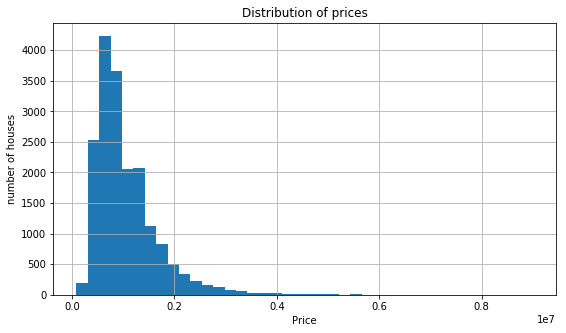

In [4]:
fig, ax = plt.subplots(1, 1, figsize = (9,5))
df['Price'].hist(bins=40, ax=ax)
plt.xlabel('Price')
plt.title('Distribution of prices')
plt.ylabel('number of houses')

In [5]:
print('Mean price and std: %d +- %d' % (df['Price'].mean(), df['Price'].std()))
print('Median price is ', df['Price'].median())
print('Max price is ', df['Price'].max())
print('Min price ', df['Price'].min())

Mean price and std: 1056697 +- 641921
Median price is  880000.0
Max price is  9000000.0
Min price  85000.0


### Handling the missing data

Let's take a look at some of the columns:

#### 'Method' variable

S - property sold; SP - property sold prior; PI - property passed in; PN - sold prior not disclosed; SN - sold not disclosed; NB - no bid; VB - vendor bid; W - withdrawn prior to auction; SA - sold after auction; SS - sold after auction price not disclosed. N/A - price or highest bid not available.

In [6]:
method_values = df['Method'].unique().tolist()
print('unique values of "Method":', method_values)

unique values of "Method": ['S', 'SP', 'PI', 'VB', 'SA']


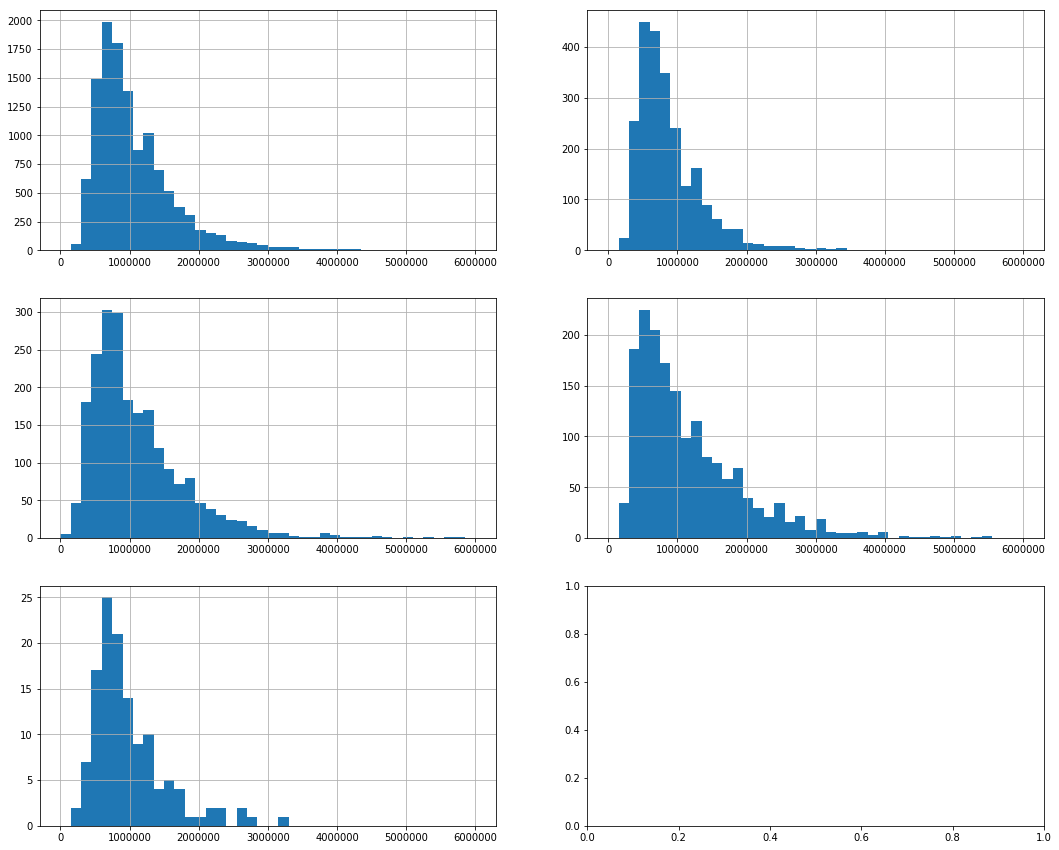

In [7]:
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(18, 15))

for i, name in enumerate(method_values):
    slice_methods = (df['Method'] == name)
    df[slice_methods]['Price'].hist(bins=40, ax=axes[i//2, i%2], range=(0, 6000000))
    

The distributions all look similar, so we'll drop this column (later)

#### 'SellerG' variable

In [8]:
seller_values = df['SellerG'].unique().tolist()
print('There are ' + repr(len(seller_values)) +  ' unique values of "SellerG"')

There are 305 unique values of "SellerG"


There are 305 sellers. In this analysis we'll not consider this variable.

#### 'Regionname' variable

In [9]:
region_values = df['Regionname'].unique().tolist()
print('unique values of "Regionname":', region_values)
region_values = region_values[:-1]

unique values of "Regionname": ['Northern Metropolitan', 'Western Metropolitan', 'Southern Metropolitan', 'Eastern Metropolitan', 'South-Eastern Metropolitan', 'Eastern Victoria', 'Northern Victoria', 'Western Victoria', nan]


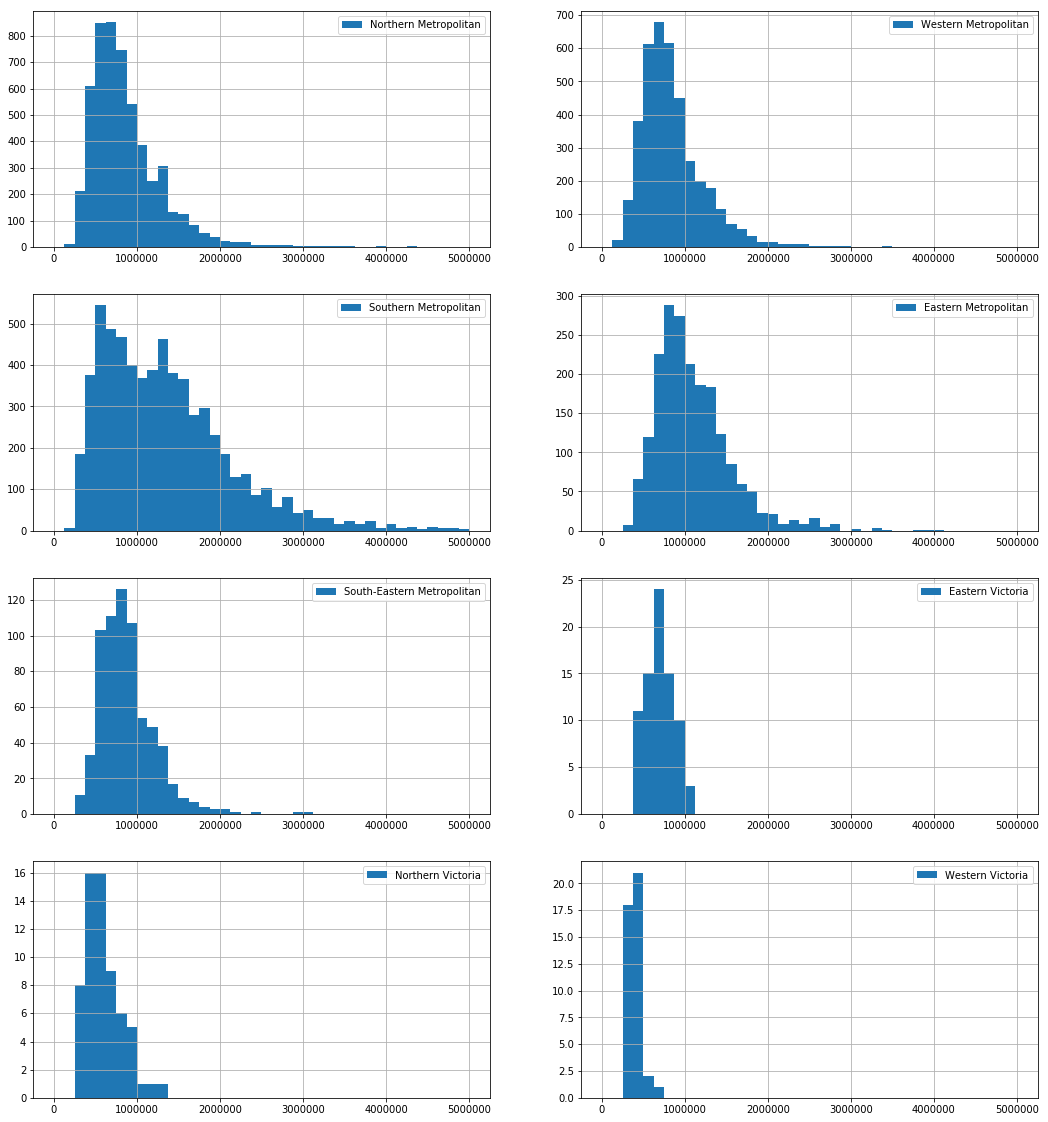

In [10]:
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(18, 20))

for i, name in enumerate(region_values):
    slice_regions = (df['Regionname'] == name)
    df[slice_regions]['Price'].hist(bins=40, ax=axes[i//2, i%2], range=(0, 5000000), label=name)
    axes[i//2, i%2].legend()

One can see that Northern Metropolitan, Western Metropolitan have similar distributions; all of the other areas seemingly have different distributions. We'll replace these two values with a new value called NWMetropolitan

In [11]:
region_mask = (df['Regionname'] =='Northern Metropolitan') ^ (df['Regionname'] =='Western Metropolitan')
df.at[region_mask, 'Regionname'] = 'NWMetropolitan'

#### Suburb

In [12]:
print('There are ', len(df['Suburb'].unique()), ' unique suburbs')
print('There are', df['Suburb'].isna().sum(), ' missing values')

There are  330  unique suburbs
There are 0  missing values


We'll use one-hot encoding for this feature

#### Address

In [13]:
print('There are', len(df['Address'].unique()), 'unique address entries')

There are 18134 unique address entries


One approach might be to leave only the name of the street, and then use one-hot encoding. However, this feature might correlate with the previous one (no analysis is provided yet), but in this survey we'll omit this feature.

In [14]:
# df.drop('Address', axis=1, inplace=True)

#### Bedroom2, Bathrooms and Rooms

In [15]:
# the correlation between these variables
df[['Bedroom2', 'Bathroom', 'Rooms']].corr()

,Bedroom2,Bathroom,Rooms
Bedroom2,1.000000,0.589968,0.948740
Bathroom,0.589968,1.000000,0.597444
Rooms,0.948740,0.597444,1.000000


Since Bedroom2 and Rooms are highly correlated, it's probably safe to drop Bedroom2 (especially since it has lots of nans)

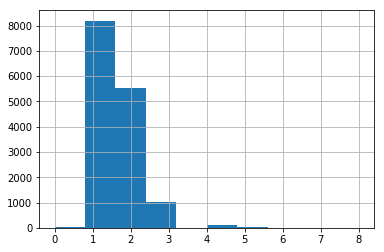

In [16]:
df['Bathroom'].hist()

(array([9.090e+02, 4.992e+03, 7.953e+03, 3.648e+03, 7.730e+02, 9.200e+01,
        1.300e+01, 1.000e+01, 1.000e+00, 4.000e+00, 0.000e+00, 1.000e+00]),
 array([ 1.        ,  1.91666667,  2.83333333,  3.75      ,  4.66666667,
         5.58333333,  6.5       ,  7.41666667,  8.33333333,  9.25      ,
        10.16666667, 11.08333333, 12.        ]),
 <a list of 12 Patch objects>)

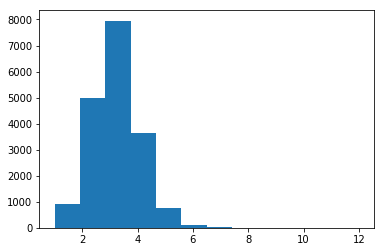

In [17]:
plt.hist(df['Rooms'], bins=12)

We need to insert some missing values in 'Bathrooms'. Most houses have at most 1-3 bathrooms and 1-5 rooms. We'll look at the histograms (of number of bathrooms) for each number of rooms

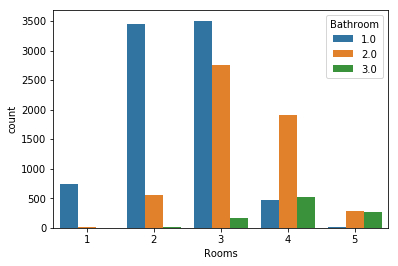

In [18]:
mask_rooms = (df['Rooms'] >= 1) & (df['Rooms'] < 6) & (df['Bathroom'] > 0) & (df['Bathroom'] < 4)
sns.countplot(data=df[mask_rooms], x='Rooms',  hue='Bathroom')

In [19]:
# this function returns number of bathrooms according to the (empirically computed) probability distributions on the diagram above
def get_bathrooms(house):
    rooms, bathrooms = house
    if np.isnan(bathrooms):
        if rooms == 1:
            return 1
        elif rooms == 2: 
            bathrooms = [1.0, 2.0]
            weights = [0.87, 0.12]
            return choices(population=bathrooms, weights=weights)[0]
        elif rooms == 3:
            bathrooms = [1.0, 2.0]
            weights = [0.55, 0.45]
            return choices(population=bathrooms, weights=weights)[0]
        elif rooms == 4:
            bathrooms = [1.0, 2.0, 3.0]
            weights = [0.2, 0.6, 0.2]
            return choices(population=bathrooms, weights=weights)[0]
        elif rooms == 5:
            bathrooms = [2.0, 3.0]
            weights = [0.5, 0.5]
            return choices(population=bathrooms, weights=weights)[0]
        elif rooms > 5:
            return 3
    else:
        return bathrooms

In [20]:
df['Bathrooms'] = df[['Rooms', 'Bathroom']].apply(get_bathrooms, axis=1)
#df.drop('Bathroom', axis=1, inplace=True)

#### Type

Type: br - bedroom(s); h - house,cottage,villa, semi,terrace; u - unit, duplex; t - townhouse; dev site - development site; o res - other residential.

In [21]:
type_values = df['Type'].unique().tolist()
print('unique values of "Type":', type_values)

unique values of "Type": ['h', 't', 'u']


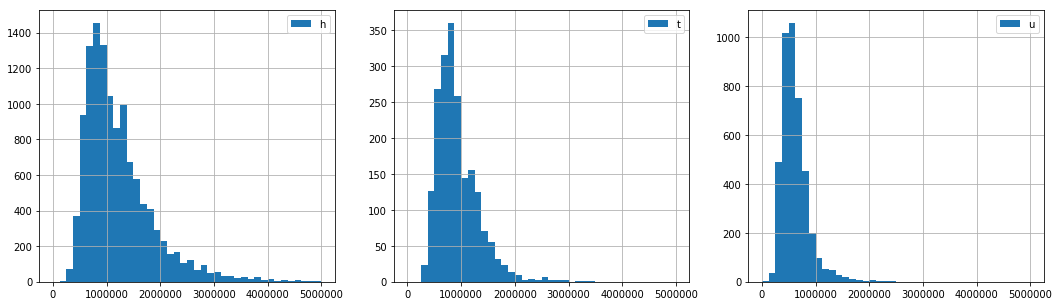

In [22]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(18, 5))

for i, name in enumerate(type_values):
    slice_types = (df['Type'] == name)
    df[slice_types]['Price'].hist(bins=40, ax=axes[i], range=(0, 5000000), label=name)
    axes[i].legend()

All three distributions are different

#### Date

In [87]:
import datetime
format_str = '%d/%m/%Y' # The format

def get_date(date_str):
    return datetime.datetime.strptime(date_str, format_str).date()

df['New Date'] = df['Date'].apply(get_date)

KeyError: 'Date'

In [86]:
plt.plot(df.groupby(df['New Date']).median()['Price'])
plt.title('Median price by date')

KeyError: 'New Date'

we'll drop dates (and all other irrelevant features) in this analysis. We'll drop Logtitude and langtitude for this analysis in an assumption that their only purpose is to calculate the suburb (which is known) and the distance to the center (which is known)

In [25]:
df.drop(['New Date', 'Date', 'SellerG', 'Method', 'Address', 'Bathroom', 'Bedroom2', 'Postcode', 'Lattitude', 'Longtitude',
         'CouncilArea'], axis=1, inplace=True)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18396 entries, 1 to 23546
Data columns (total 12 columns):
Suburb           18396 non-null object
Rooms            18396 non-null int64
Type             18396 non-null object
Price            18396 non-null float64
Distance         18395 non-null float64
Car              14820 non-null float64
Landsize         13603 non-null float64
BuildingArea     7762 non-null float64
YearBuilt        8958 non-null float64
Regionname       18395 non-null object
Propertycount    18395 non-null float64
Bathrooms        18396 non-null float64
dtypes: float64(8), int64(1), object(3)
memory usage: 1.8+ MB


In [27]:
#there's one nan in Regionname
df.dropna(subset=['Regionname'], inplace=True)

#### More processing data (dummies)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18395 entries, 1 to 23546
Data columns (total 12 columns):
Suburb           18395 non-null object
Rooms            18395 non-null int64
Type             18395 non-null object
Price            18395 non-null float64
Distance         18395 non-null float64
Car              14820 non-null float64
Landsize         13603 non-null float64
BuildingArea     7762 non-null float64
YearBuilt        8958 non-null float64
Regionname       18395 non-null object
Propertycount    18395 non-null float64
Bathrooms        18395 non-null float64
dtypes: float64(8), int64(1), object(3)
memory usage: 1.8+ MB


The remaining columns 'Car', 'BuildingArea', 'YearBuilt', 'Landsize' seem to be very relevant to the analysis

In [89]:
X = df.drop('Price', axis=1)

cols_with_no_nan = X.columns[X.notna().all()]
cols_with_missing_data = df.columns[df.isna().any()]

X_full = X[cols_with_no_nan]
y = df['Price'] / df['Price'].max() # we normalized the prices, otherwise the scores are too big

cat_dummies = pd.get_dummies(X[['Suburb', 'Type', 'Regionname']])

# X_dummies is the dataset with categorical values replaced by dummies
X_dummies = X_full.copy()
X_dummies.drop(['Suburb', 'Type', 'Regionname'], axis=1, inplace=True)
X_full = X_dummies.join(cat_dummies) #now X_full has only columns with no nan and dummies for cat.data

X_train_full, X_test_full, y_train, y_test = train_test_split(X_full, y, test_size=0.25)

In [46]:
from sklearn.impute import SimpleImputer

simple_imputer = SimpleImputer()

X_impute = X.copy() # X_impute will contain imputed columns
X_impute.drop(['Suburb', 'Type', 'Regionname'], axis=1, inplace=True)
X_impute = X_impute.join(cat_dummies)

X_train_impute = X_impute.loc[X_train_full.index]
X_test_impute = X_impute.loc[X_test_full.index] # we split imputed data in the same way as 'full' data (columns with no nan)

copy_X_train = X_train_impute.copy()
copy_X_test = X_test_impute.copy()

X_train_impute = pd.DataFrame(simple_imputer.fit_transform(X=X_train_impute))
X_train_impute.columns = copy_X_train.columns
X_test_impute = pd.DataFrame(simple_imputer.transform(X=X_test_impute))
X_test_impute.columns = copy_X_test.columns

The simple imputer is too naive: it substitutes nans with mean or median. Nevertheless, let's compare the base results; after that we'll return to the remaining 4 features ('Car', 'YearBuilt', 'BuildingArea', 'LandArea')

In [79]:
X.columns

Index(['Suburb', 'Rooms', 'Type', 'Distance', 'Car', 'Landsize',
       'BuildingArea', 'YearBuilt', 'Regionname', 'Propertycount',
       'Bathrooms'],
      dtype='object')

### Comparative base regression results for the original and imputed train sets

In [47]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [48]:
def regression_model_scores(model, y_pred, y_true):
    print('square root of mean squared error: %.4f' % (mean_squared_error(y_true, y_pred)) ** 0.5)
    print('mean absolute error: %.4f' % (mean_absolute_error(y_true, y_pred)))
    print('variance score: %.4f' % (r2_score(y_true, y_pred)))

##### Linear regression with no regulatization:

In [57]:
linear_model_full = LinearRegression() #again, full stands for the 'full'  dataset we train it on

linear_model_full.fit(X_train_full, y_train)
y_pred_full = linear_model_full.predict(X_test_full)
regression_model_scores(model=linear_model_full, y_pred=y_pred_full, y_true=y_test)

square root of mean squared error: 960.4669
mean absolute error: 37.3150
variance score: -169171909.3725


In [50]:
linear_model_impute = LinearRegression() # model is trained on imputed data

linear_model_impute.fit(X_train_impute, y_train)
y_pred_impute = linear_model_impute.predict(X_test_impute)
regression_model_scores(model=linear_model_impute, y_pred=y_pred_impute, y_true=y_test)

square root of mean squared error: 742.1145
mean absolute error: 29.7414
variance score: -100996235.4686


Even the naive imputer seemingly improves the scores. (I have no idea why the variance is so big)

##### Ridge regression 

In [65]:
alphas = [0.1, 0.2, 0.5, 0.75, 1.0, 1.3, 1.6, 2.0, 3.0, 5.0]
params = {'alpha': alphas}

ridge_model_full = Ridge()
grid_search_ridge_full = GridSearchCV(estimator=ridge_model_full, param_grid=params, cv=5, scoring='r2')

grid_search_ridge_full.fit(X_train_full, y_train)
best_ridge_full = grid_search_ridge_full.best_estimator_
y_pred_full = best_ridge_full.predict(X_test_full)

regression_model_scores(best_ridge_full, y_pred=y_pred_full, y_true=y_test)
print(grid_search_ridge_full.best_params_)

square root of mean squared error: 0.0438
mean absolute error: 0.0279
variance score: 0.6480
{'alpha': 2.0}


In [67]:
ridge_model_impute = Ridge()
grid_search_ridge_impute = GridSearchCV(estimator=ridge_model_impute, param_grid=params, cv=5, scoring='r2')

grid_search_ridge_impute.fit(X_train_impute, y_train)
best_ridge_impute = grid_search_ridge_impute.best_estimator_
y_pred_impute = best_ridge_impute.predict(X_test_impute)

regression_model_scores(best_ridge_impute, y_pred=y_pred_impute, y_true=y_test)
print(grid_search_ridge_full.best_params_)

square root of mean squared error: 0.0434
mean absolute error: 0.0275
variance score: 0.6540
{'alpha': 2.0}


##### Lasso regression

In [69]:
alphas = [0.1, 0.2, 0.5, 0.75, 1.0, 1.3, 1.6, 2.0, 3.0, 5.0]
params = {'alpha': alphas}

lasso_model_full = Lasso()
grid_search_lasso_full = GridSearchCV(estimator=lasso_model_full, param_grid=params, cv=5, scoring='r2')

grid_search_lasso_full.fit(X_train_full, y_train)
best_lasso_full = grid_search_lasso_full.best_estimator_
y_pred_full = best_lasso_full.predict(X_test_full)

regression_model_scores(best_lasso_full, y_pred=y_pred_full, y_true=y_test)
print(grid_search_lasso_full.best_params_)

square root of mean squared error: 0.0738
mean absolute error: 0.0519
variance score: 0.0018
{'alpha': 0.1}


In [71]:
lasso_model_impute = Lasso()
grid_search_lasso_impute = GridSearchCV(estimator=lasso_model_impute, param_grid=params, cv=5, scoring='r2')

grid_search_lasso_impute.fit(X_train_impute, y_train)
best_lasso_impute = grid_search_lasso_impute.best_estimator_
y_pred_impute = best_lasso_impute.predict(X_test_impute)

regression_model_scores(best_lasso_impute, y_pred=y_pred_impute, y_true=y_test)
print(grid_search_lasso_impute.best_params_)

square root of mean squared error: 0.0738
mean absolute error: 0.0520
variance score: 0.0018
{'alpha': 3.0}


A small conclusion: ridge regression seems to return a better model, and the the results on the imputed data are slightly better. There's some space to find better methods to fill the missing data and find better regression algorithms.

### Handling the missing data (continued)

In [90]:
X.drop(['Suburb', 'Type', 'Regionname'], axis=1, inplace=True)
X = X.join(cat_dummies)


X_train = X.loc[X_train_full.index]
X_test = X.loc[X_test_full.index] # we split imputed data in the same way as 'full' data (columns with no nan)

#### Car

In [92]:
X_train[['Rooms', 'Car']].corr()

,Rooms,Car
Rooms,1.000000,0.414481
Car,0.414481,1.000000


There's probably some link between these two features. we'll try to use the same trick as before with 'Bathrooms'

Text(0.5, 1.0, 'Count distribution of parking spots')

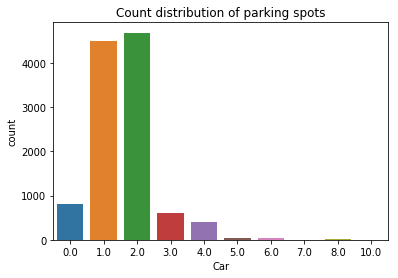

In [173]:
sns.countplot(X_train['Car'])
plt.title('Count distribution of parking spots')

Text(0.5, 1.0, 'Distribution of house prices with respect to the number of parking spots')

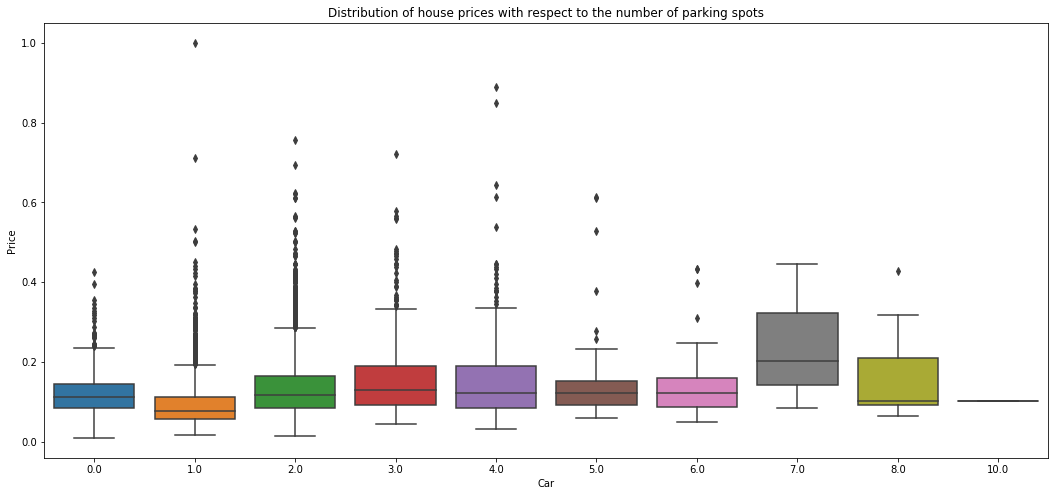

In [174]:
fig, ax = plt.subplots(figsize=(18, 8))
sns.boxplot(ax=ax, x=X_train['Car'], y=y_train)
plt.title('Distribution of house prices with respect to the number of parking spots')

In [128]:
print('There are %.0f houses with at least 7 car spots' %(df[df['Car'] > 6].shape[0]))

There are 24 houses with at least 7 car spots


Strangely, it doesn't look like this feature plays an important role. The upper bound for the 0.75 percentile, 0.25 percentile and the median are almost the same for all values of 'Car' between 0 and 6. The statistics for 'Car' between 7 and 10 may probably inaccurate due to small number of corresponding instances (even though it's logical to assume that the more parking spots the higher the price). One may wonder why the median price for houses with no car spots are higher than the 0.75 percentile for houses with 1 parking spot. It might be due to the fact that there are probably a lot of expensive apartments in apartment blocks sold without parking spots, but a house with 1 parking spot is guaranteed to be cheaper.

In [136]:
df['Suburb'].unique()

array(['Abbotsford', 'Airport West', 'Albert Park', 'Alphington',
       'Altona', 'Altona North', 'Armadale', 'Ascot Vale', 'Ashburton',
       'Ashwood', 'Avondale Heights', 'Balaclava', 'Balwyn',
       'Balwyn North', 'Bentleigh', 'Bentleigh East', 'Box Hill',
       'Braybrook', 'Brighton', 'Brighton East', 'Brunswick',
       'Brunswick West', 'Bulleen', 'Burwood', 'Camberwell', 'Canterbury',
       'Carlton North', 'Carnegie', 'Caulfield', 'Caulfield North',
       'Caulfield South', 'Chadstone', 'Clifton Hill', 'Coburg',
       'Coburg North', 'Collingwood', 'Doncaster', 'Eaglemont',
       'Elsternwick', 'Elwood', 'Essendon', 'Essendon North', 'Fairfield',
       'Fitzroy', 'Fitzroy North', 'Flemington', 'Footscray', 'Glen Iris',
       'Glenroy', 'Gowanbrae', 'Hadfield', 'Hampton', 'Hampton East',
       'Hawthorn', 'Heidelberg Heights', 'Heidelberg West', 'Hughesdale',
       'Ivanhoe', 'Kealba', 'Keilor East', 'Kensington', 'Kew',
       'Kew East', 'Kooyong', 'Maidstone', 

Let's compare the distributions of number of cars in different suburbs:

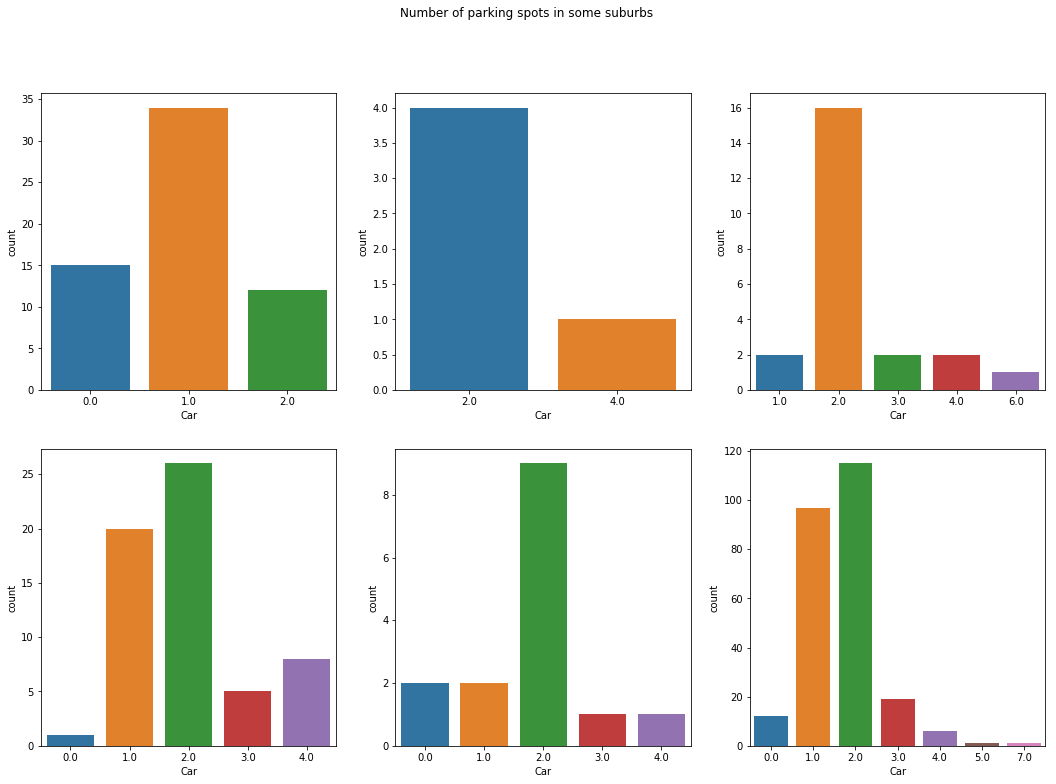

In [177]:
some_suburbs = ['Abbotsford', 'Croydon Hills', 'Wantirna South', 'Canterbury', 'Vermont', 'Preston']
figure, axes = plt.subplots(2,3, figsize=(18,12))

plt.suptitle('Number of parking spots in some suburbs')

for i in range(2):
    for j in range(3):
        sns.countplot(ax=axes[i, j], x=df[df['Suburb'] == some_suburbs[i*3 + j]]['Car'])        

The distributions are different (rich and poor suburbs). It is possible to fill missing data randomly according to these distributions, but we'll use regression (on known columns).

#### Year

In [39]:
years = df[['YearBuilt', 'Price']]
years.dropna(inplace=True)

C:\Users\Temirlan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


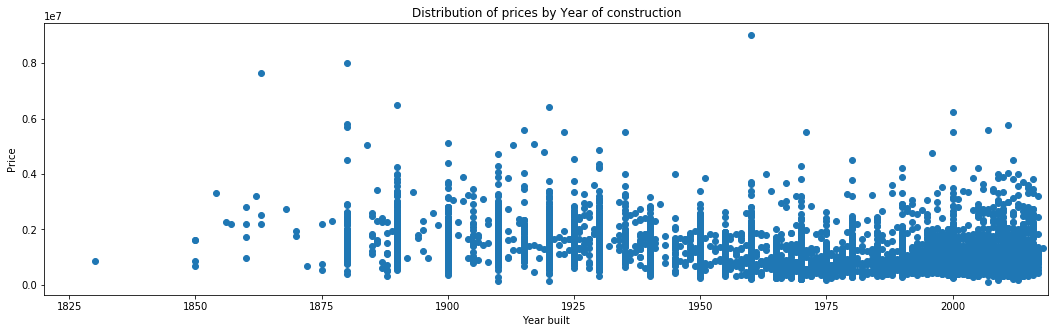

In [151]:
plt.figure(figsize=(18,5))
plt.title('Distribution of prices by Year of construction')
plt.scatter(x=df['YearBuilt'], y=df['Price'])
plt.xlim(1820, 2019)
plt.xlabel('Year built')
plt.ylabel('Price')
plt.show()